#### Import Required Libraries

In [ ]:
# Minor doc/comment update for clarity (re-PR for tracking)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_recall_fscore_support)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import plot_model

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-10-18 10:16:52.757443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760782613.004187      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760782613.083030      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Loading preprocessed data...")
data = np.load('/kaggle/input/ecg-mitdb-processed/ecg_mitdb_processed.npz')
X = data['X']
y = data['y']
label_names = data['label_names']

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Classes: {label_names}")


Loading preprocessed data...
Data shape: X=(112559, 250, 1), y=(112559, 5)
Classes: ['F' 'N' 'Q' 'S' 'V']


In [3]:
print("\nSplitting data...")
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1)
)

# Second split: 80% train, 20% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Splitting data...
Train set: 72037 samples
Validation set: 18010 samples
Test set: 22512 samples


In [4]:
# ===========================================================
# 🎯 Focused Bayesian LSTM Hyperparameter Scan (Quick Version)
# ===========================================================

import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, callbacks, models

print("\n🔧 Starting Focused Quick Bayesian Scan...")

# ----------------------------
# Early stopping & LR reduction
# ----------------------------
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# ----------------------------
# Build model
# ----------------------------
def build_lstm_model(hp):
    model = keras.Sequential()

    # --- First LSTM layer ---
    units1 = hp.Int('lstm1_units', 96, 160, step=32)
    bidir = hp.Boolean('bidirectional', default=False)
    dropout1 = hp.Float('dropout1', 0.2, 0.4, step=0.1)

    lstm1 = layers.LSTM(units1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
    if bidir:
        lstm1 = layers.Bidirectional(lstm1)
    model.add(lstm1)
    model.add(layers.Dropout(dropout1))
    model.add(layers.BatchNormalization())

    # --- Second LSTM layer ---
    units2 = hp.Int('lstm2_units', 24, 40, step=8)
    dropout2 = hp.Float('dropout2', 0.2, 0.4, step=0.1)
    lstm2 = layers.LSTM(units2)
    if bidir:
        lstm2 = layers.Bidirectional(lstm2)
    model.add(lstm2)
    model.add(layers.Dropout(dropout2))
    model.add(layers.BatchNormalization())

    # --- Dense layers ---
    dense1 = hp.Int('dense1_units', 48, 80, step=16)
    dense2 = hp.Int('dense2_units', 24, 32, step=8)
    model.add(layers.Dense(dense1, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(dense2, activation='relu'))
    model.add(layers.Dropout(0.2))

    # --- Output layer ---
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    # --- Optimizer ---
    lr = hp.Choice('learning_rate', [1e-3, 7e-4, 5e-4])
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# ----------------------------
# Focused Bayesian tuner (quick version)
# ----------------------------
tuner = kt.BayesianOptimization(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=12,              
    num_initial_points=2,     
    overwrite=True
)

# ----------------------------
# Search (short epochs to estimate trend)
# ----------------------------
tuner.search( 
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ----------------------------
# Get best hyperparameters
# ----------------------------
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("\n🏆 Best Hyperparameters (Focused Quick Scan):")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")




Trial 12 Complete [00h 05m 18s]
val_accuracy: 0.9738478660583496

Best val_accuracy So Far: 0.9738478660583496
Total elapsed time: 01h 00m 17s

🏆 Best Hyperparameters (Focused Quick Scan):
lstm1_units: 96
bidirectional: True
dropout1: 0.4
lstm2_units: 40
dropout2: 0.2
dense1_units: 48
dense2_units: 32
learning_rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("\n🏆 Best Hyperparameters (Quick Scan):")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")
    
# Callbacks
# ----------------------------
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5
)


checkpoint_cb = callbacks.ModelCheckpoint(
    "best_lstm_model.h5",           
    monitor="val_loss",            
    save_best_only=True,           
    mode="min",                   
    verbose=1
)

# Final Training with adaptive callbacks
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, reduce_lr, checkpoint_cb],  
    verbose=1
)




🏆 Best Hyperparameters (Quick Scan):
lstm1_units: 96
bidirectional: True
dropout1: 0.4
lstm2_units: 40
dropout2: 0.2
dense1_units: 48
dense2_units: 32
learning_rate: 0.001
Epoch 1/50
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9664 - loss: 0.1198
Epoch 1: val_loss improved from inf to 0.10141, saving model to best_lstm_model.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.9664 - loss: 0.1198 - val_accuracy: 0.9707 - val_loss: 0.1014 - learning_rate: 0.0010
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9696 - loss: 0.1091
Epoch 2: val_loss improved from 0.10141 to 0.09198, saving model to best_lstm_model.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - accuracy: 0.9696 - loss: 0.1091 - val_accuracy: 0.9721 - val_loss: 0.0920 - learning_rate: 0.0010
Epoch 3/50
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9701 - loss: 0.1064
Epoch 3: val_loss did not improve from 0.09198
563/563 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - accuracy: 0.9701 -

In [6]:
print("\n" + "="*70)
print("EVALUATION ON TEST SET")
print("="*70)


y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Evaluate on test data 

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

# Per-class metrics

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print("\nPer-Class Detailed Metrics:")
print("-" * 70)
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for i, label in enumerate(label_names):
    print(f"{label:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")



EVALUATION ON TEST SET
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step

Test Loss: 0.0528
Test Accuracy: 0.9854

Classification Report:
              precision    recall  f1-score   support

           F     0.8477    0.8000    0.8232       160
           N     0.9903    0.9951    0.9927     18119
           Q     0.9789    0.9767    0.9778      2230
           S     0.9510    0.8381    0.8910       556
           V     0.9597    0.9537    0.9567      1447

    accuracy                         0.9854     22512
   macro avg     0.9455    0.9127    0.9283     22512
weighted avg     0.9852    0.9854    0.9852     22512


Per-Class Detailed Metrics:
----------------------------------------------------------------------
Class      Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
F          0.8477       0.8000       0.8232       160       
N          0.9903       0.9951       0.9927       18119     
Q          0.9789       0.


CONFUSION MATRIX

Confusion Matrix (raw counts):
[[  128    25     0     0     7]
 [   10 18031    32    21    25]
 [    0    31  2178     1    20]
 [    0    80     4   466     6]
 [   13    41    11     2  1380]]


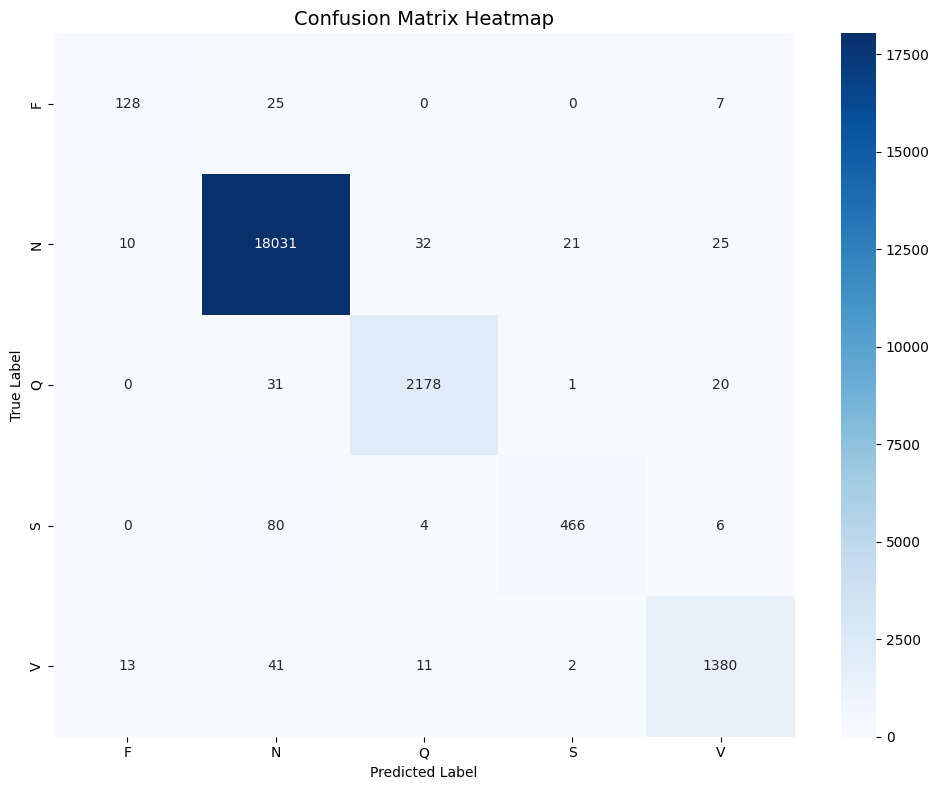

In [7]:
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix

cm = confusion_matrix(y_true, y_pred)

# Print numeric matrix

print("\nConfusion Matrix (raw counts):")
print(cm)

# Plot without saving

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix Heatmap", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
